# **Clasificación**


In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# MNIST

In [4]:
from sklearn.datasets import fetch_openml;
mnist = fetch_openml('mnist_784', version=1, as_frame=False);
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [5]:

X, y = mnist["data"], mnist["target"];

X.shape


(70000, 784)

In [6]:

y.shape

(70000,)

In [7]:
28*28


784

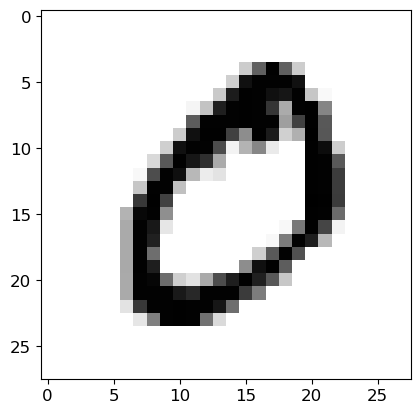

In [8]:
%matplotlib inline
import matplotlib as mpl;
import matplotlib.pyplot as plt;

some_digit = X[1];
some_digit_image = some_digit.reshape(28,28);
plt.imshow(some_digit_image, cmap=mpl.cm.binary);


In [9]:
y[1]

'0'

In [10]:
y = y.astype(np.int8)

In [11]:
y[1]

0

In [12]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,interpolation="nearest")
    plt.axis("off")

In [13]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    n_rows = (len(instances) - 1) // images_per_row + 1
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size, images_per_row * size)
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

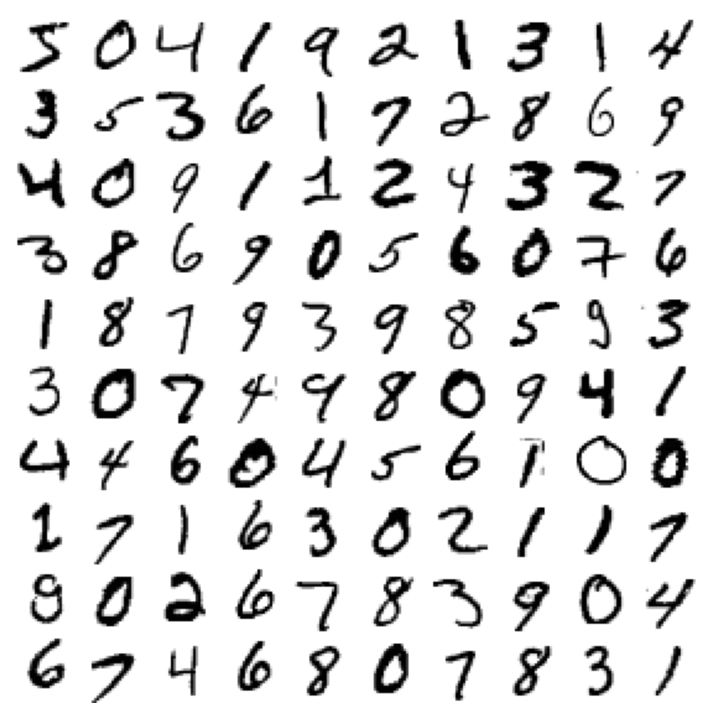

In [14]:

plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
plt.show()

In [19]:
y[0], y[1], y[2]

(5, 0, 4)

In [20]:
X_train, X_test, y_train, y_test= X[:60_000], X[60_000:],y[:60_000],y[60_000:] 

# Entrenando un clasificador binario

Para ello vamos a considerar un clasificador que predice si una entrada es la imagen de un 5 o no.

In [21]:
y_train_5 = (y_train==5)
y_test_5  = (y_test ==5)

y_train_5[:10]

array([ True, False, False, False, False, False, False, False, False,
       False])

In [22]:
from sklearn.linear_model import SGDClassifier;

sgd_clf = SGDClassifier(max_iter=1000, random_state=42)
sgd_clf.fit(X_train, y_train_5)


SGDClassifier(random_state=42)

In [23]:
sgd_clf.predict([  X[0], X[1], X[2]  ])

array([ True, False, False])

# Medidas del rendimiento

## Midiendo la precisión por medio de la validación cruzada

In [24]:
from sklearn.model_selection import cross_val_score;

cross_val_score(sgd_clf,X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Esta validación cruzada tiene el defecto que no podemos controlar la cantidad de '5's que hay en cada grupo, introduciendo por tanto sesgos.
Para ello usamos **StratifiedKFold**, una heramienta que divide el conjunto de datos de forma que permanecen en igual proporción ambas categorías (5s y no 5s).

In [25]:
from sklearn.model_selection import StratifiedKFold;

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42);

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = SGDClassifier(max_iter=1000, random_state=42);
    X_train_folds = X_train[train_index];
    y_train_folds = y_train_5[train_index];
    X_test_fold = X_train[test_index];
    y_test_fold = y_train_5[test_index];

    clone_clf.fit(X_train_folds, y_train_folds);
    y_pred = clone_clf.predict(X_test_fold);
    n_correct = sum(y_pred == y_test_fold);
    print(n_correct / len(y_pred));

0.9669
0.91625
0.96785


Todo pinta bien, ¿no? bastante preciso. Peeeero .....

Vamos a hacer un clasificador propio, desde cero.

In [26]:
from sklearn.base import BaseEstimator;

class Never5Classifier(BaseEstimator):
    
    def fit(self, X, y=None):
        pass;
    
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool);





In [27]:
never_5_clf = Never5Classifier();
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

**Acabamos de hacer un clasificador binario nulo (siempre predice False), que tiene una precisión de más del 90% de media!!**

## Matriz de confusión

In [28]:
# En vez de el score, nos devuelve las predicciones
from sklearn.model_selection import cross_val_predict;

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [29]:
from sklearn.metrics import confusion_matrix;

confusion_matrix(y_train_5, y_train_pred)


array([[53892,   687],
       [ 1891,  3530]])

In [30]:
y_train_perfect_prediction = y_train_5
confusion_matrix(y_train_5, y_train_perfect_prediction)




array([[54579,     0],
       [    0,  5421]])

## Precision y Recall

In [31]:
from sklearn.metrics import precision_score, recall_score;

precision_score(y_train_5, y_train_perfect_prediction)

1.0

In [32]:

cm = confusion_matrix(y_train_5, y_train_pred);
cm[1,1]/(cm[0,1]+cm[1,1])

0.8370879772350012

In [81]:

recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [82]:

cm[1,1]/(cm[1,0]+cm[1,1])

0.6511713705958311

In [33]:
from sklearn.metrics import f1_score;

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [34]:
cm[1,1]/(cm[0,1]+(cm[1,0]+cm[1,1])/2)

1.0389992641648271

## El equilibro entre Precision y Recall

In [39]:
from sklearn.metrics import precision_recall_curve;

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function");

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores);


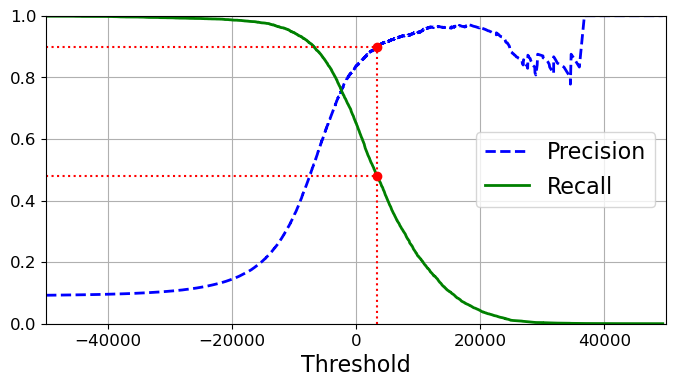

In [40]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2);
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2);
    plt.legend(loc="center right", fontsize=16);
    plt.xlabel("Threshold", fontsize=16);
    plt.grid(True);
    plt.axis([-50000, 50000, 0, 1]);

recall_90_precision = recalls[np.argmax(precisions >= 0.90)];
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)];

plt.figure(figsize=(8, 4));
plot_precision_recall_vs_threshold(precisions, recalls, thresholds);
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:");
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:");
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:");
plt.plot([threshold_90_precision], [0.9], "ro");
plt.plot([threshold_90_precision], [recall_90_precision], "ro");
plt.show();

True

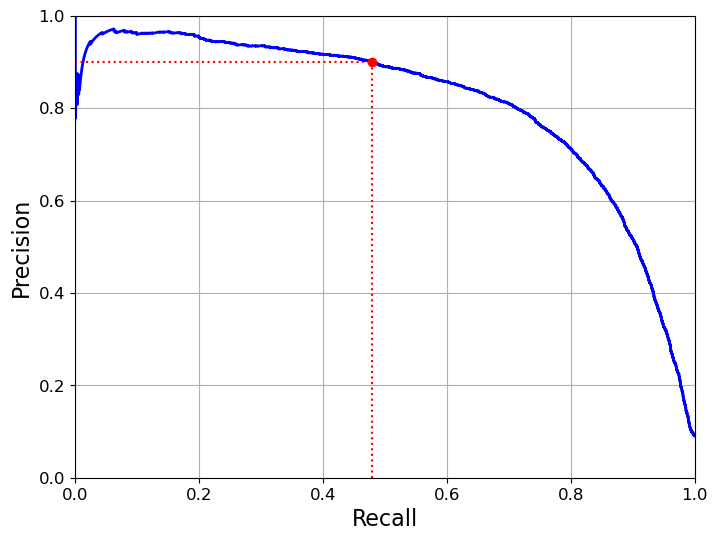

In [41]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2);
    plt.xlabel("Recall", fontsize=16);
    plt.ylabel("Precision", fontsize=16);
    plt.axis([0, 1, 0, 1]);
    plt.grid(True);

plt.figure(figsize=(8, 6));
plot_precision_vs_recall(precisions, recalls);
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:");
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:");
plt.plot([recall_90_precision], [0.9], "ro");
plt.show();

3370.0194991439557

0.9000345901072293

0.4799852425751706

## The ROC Curve

In [44]:
from sklearn.metrics import roc_curve;

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores);

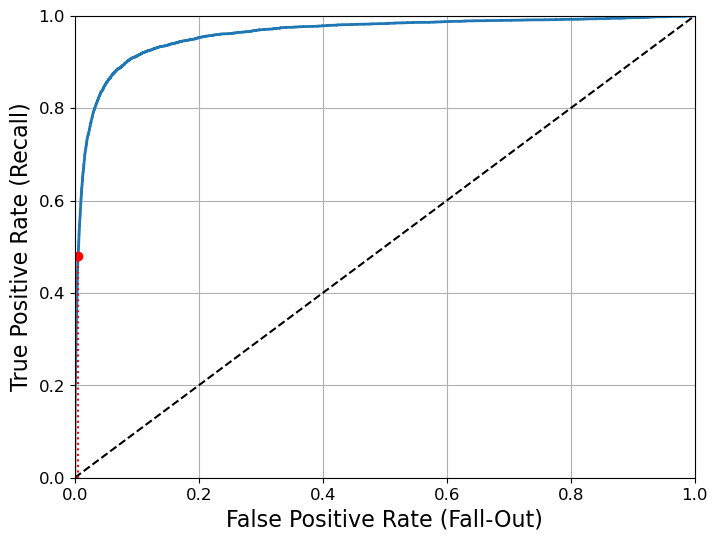

In [45]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label);
    plt.plot([0, 1], [0, 1], 'k--');
    plt.axis([0, 1, 0, 1]);
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16);
    plt.ylabel('True Positive Rate (Recall)', fontsize=16);
    plt.grid(True);

plt.figure(figsize=(8, 6));
plot_roc_curve(fpr, tpr);
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)];
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:");
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:");
plt.plot([fpr_90], [recall_90_precision], "ro");
plt.show();

In [46]:
from sklearn.metrics import roc_auc_score;

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [48]:
from sklearn.ensemble import RandomForestClassifier;

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)

y_probas_forest = cross_val_predict(forest_clf,X_train, y_train_5, cv=3,method="predict_proba");

In [51]:
y_scores_forest=y_probas_forest[:,1];

fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest);

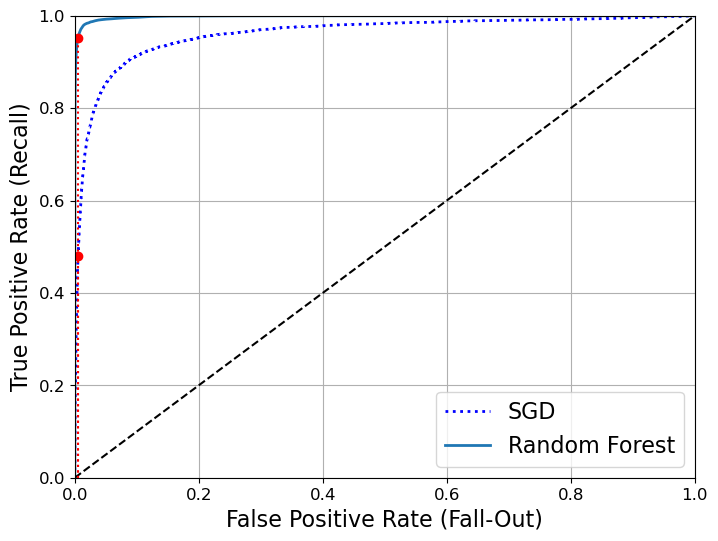

In [52]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)];

plt.figure(figsize=(8, 6));
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD");
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest");
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:");
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:");
plt.plot([fpr_90], [recall_90_precision], "ro");
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:");
plt.plot([fpr_90], [recall_for_forest], "ro");
plt.grid(True);
plt.legend(loc="lower right", fontsize=16);
plt.show();

In [53]:
roc_auc_score(y_train_5,y_scores_forest)

0.9983436731328145

In [56]:
y_train_pred_forest = cross_val_predict(forest_clf,X_train,y_train_5,cv=3);
precision_score(y_train_5,y_train_pred_forest)


0.9905083315756169

In [57]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

# Clasificación multiclase

In [68]:
from sklearn.svm import SVC;

svm_clf = SVC(gamma="auto", random_state=42);
svm_clf.fit(X_train[:1000], y_train[:1000]);
svm_clf.predict([ some_digit ])


array([0], dtype=int8)

In [69]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores


array([[ 9.29838234,  7.09167958,  3.82972099,  1.79572006,  5.8885703 ,
         0.7913911 ,  2.80027801,  8.10392157, -0.22656281,  4.83753243]])

In [70]:
np.argmax(some_digit_scores)

0

In [71]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [72]:
svm_clf.classes_[5]

5

In [73]:
from sklearn.multiclass import OneVsRestClassifier;

ovr_clf = OneVsRestClassifier( SVC(gamma="auto", random_state=42) );
ovr_clf.fit(X_train[:1000], y_train[:1000]);
ovr_clf.predict([some_digit])

array([0], dtype=int8)

In [74]:
len(ovr_clf.estimators_)

10

In [75]:
sgd_clf.fit(X_train, y_train);
sgd_clf.predict([some_digit])

array([0], dtype=int8)

In [76]:
sgd_clf.decision_function([some_digit])

array([[ 14390.59839396, -36919.31719967,  -9811.47434817,
         -8054.56345089, -21825.25725463, -11313.62371972,
        -23649.39025808, -15986.78463914,  -3798.52944589,
        -10635.46503726]])

**Warning**: las dos celdas siguientes pueden tardar en ejecutarse más de 30 minutos, dependiendo del hardware que uses.

In [77]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [80]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# Error Analysis

In [83]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx 


array([[5635,    0,   61,   10,   16,   50,   46,    7,   66,   32],
       [   3, 6393,   95,   21,   16,   47,   15,   27,  109,   16],
       [  72,   56, 5174,   89,   69,   39,  163,   66,  212,   18],
       [  58,   32,  217, 4941,   23,  441,   32,   56,  216,  115],
       [  11,   26,   46,    6, 5298,   26,   73,   32,   87,  237],
       [  68,   23,   58,  150,   83, 4606,  174,   26,  152,   81],
       [  40,   13,   56,    6,   22,  113, 5625,    5,   36,    2],
       [  23,   24,  103,   36,  124,   40,   10, 5228,   75,  602],
       [  40,  101,  158,  122,   49,  457,   77,   35, 4666,  146],
       [  33,   18,   66,   83,  515,  127,    4,  485,  166, 4452]])

In [84]:
def plot_confusion_matrix(matrix):
    fig = plt.figure(figsize=(8,8));
    ax = fig.add_subplot(111);
    cax = ax.matshow(matrix);
    fig.colorbar(cax);

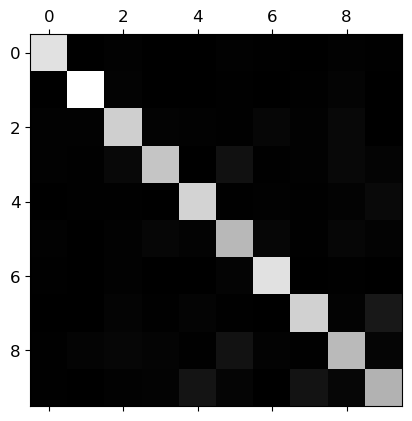

In [85]:

plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()


In [87]:

row_sum = conf_mx.sum(axis=1,keepdims=True)
norm_conf_mx = conf_mx / row_sum
norm_conf_mx


array([[9.51375992e-01, 0.00000000e+00, 1.02988350e-02, 1.68833361e-03,
        2.70133378e-03, 8.44166807e-03, 7.76633463e-03, 1.18183353e-03,
        1.11430019e-02, 5.40266757e-03],
       [4.44971818e-04, 9.48234945e-01, 1.40907743e-02, 3.11480273e-03,
        2.37318303e-03, 6.97122516e-03, 2.22485909e-03, 4.00474637e-03,
        1.61673094e-02, 2.37318303e-03],
       [1.20845921e-02, 9.39912722e-03, 8.68412219e-01, 1.49378986e-02,
        1.15810675e-02, 6.54582075e-03, 2.73581739e-02, 1.10775428e-02,
        3.55824102e-02, 3.02114804e-03],
       [9.46012070e-03, 5.21937694e-03, 3.53938999e-02, 8.05904420e-01,
        3.75142717e-03, 7.19295384e-02, 5.21937694e-03, 9.13390964e-03,
        3.52307943e-02, 1.87571359e-02],
       [1.88291681e-03, 4.45053064e-03, 7.87401575e-03, 1.02704553e-03,
        9.06881205e-01, 4.45053064e-03, 1.24957206e-02, 5.47757617e-03,
        1.48921602e-02, 4.05682985e-02],
       [1.25438111e-02, 4.24275964e-03, 1.06991330e-02, 2.76701716e-02,
   

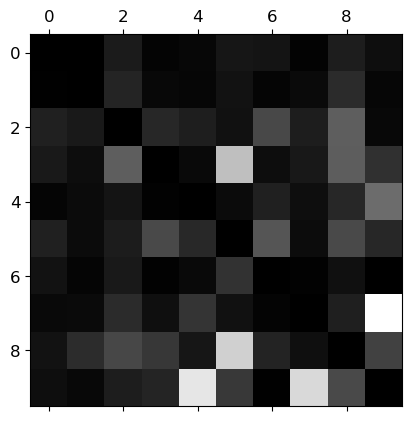

In [92]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()


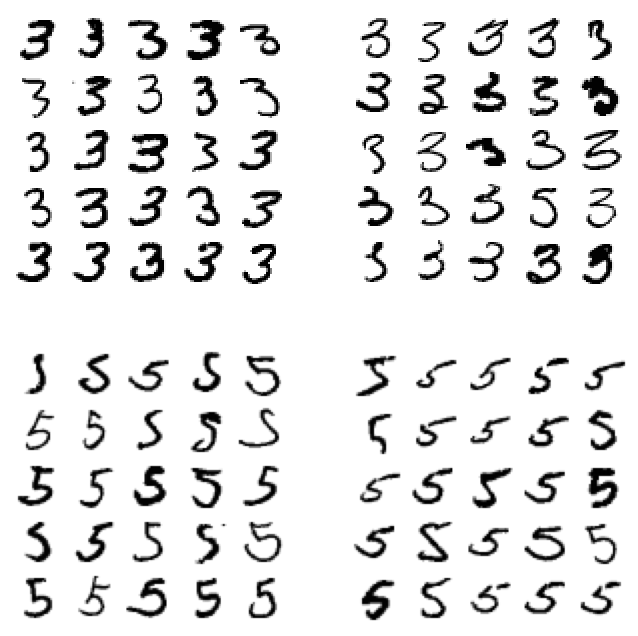

In [90]:
cl_a, cl_b = 3, 5;
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)];
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)];
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)];
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)];

plt.figure(figsize=(8,8));
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5);
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5);
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5);
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5);
plt.show();